# Lesson 5: Human in the Loop

Note: This notebook is running in a later version of langgraph that it was filmed with. The later version has a couple of key additions:
- Additional state information is stored to memory and displayed when using `get_state()` or `get_state_history()`.
- State is additionally stored every state transition while previously it was stored at an interrupt or at the end.
These change the command output slightly, but are a useful addtion to the information available.

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
#from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
from IPython.display import Image, display
import sqlite3
conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn)
#memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
import os
from langchain_groq import ChatGroq
model = ChatGroq(model_name="llama3-groq-70b-8192-tool-use-preview", api_key=os.environ.get("GROQ_API_KEY"))

In [4]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [5]:
tool = TavilySearchResults(max_results=2)

## Manual human approval

In [6]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_llm)
        graph.add_node("action", self.take_action)
        
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")

        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        display(Image(self.graph.get_graph().draw_mermaid_png()))
        
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_llm(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

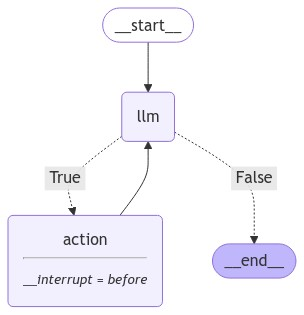

In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
#model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [8]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fwr5', 'function': {'arguments': '{"query": "weather in sf"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 293, 'total_tokens': 325, 'completion_time': 0.099441301, 'prompt_time': 0.022065403, 'queue_time': 0.010820216999999997, 'total_time': 0.121506704}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-21415c53-fd87-4013-b63d-951908dd1630-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': 'call_fwr5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 293, 'output_tokens': 32, 'total_tokens': 325}), ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \

In [9]:
print(abot.graph.get_state(thread))

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fwr5', 'function': {'arguments': '{"query": "weather in sf"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 293, 'total_tokens': 325, 'completion_time': 0.099441301, 'prompt_time': 0.022065403, 'queue_time': 0.010820216999999997, 'total_time': 0.121506704}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-21415c53-fd87-4013-b63d-951908dd1630-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': 'call_fwr5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 293, 'output_tokens': 32, 'total_tokens': 325}), ToolMessage(content='[{\'url\': \'https://www

In [10]:
abot.graph.get_state(thread).next

()

### continue after interrupt

In [11]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

In [12]:
print(abot.graph.get_state(thread))

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fwr5', 'function': {'arguments': '{"query": "weather in sf"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 293, 'total_tokens': 325, 'completion_time': 0.099441301, 'prompt_time': 0.022065403, 'queue_time': 0.010820216999999997, 'total_time': 0.121506704}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-21415c53-fd87-4013-b63d-951908dd1630-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': 'call_fwr5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 293, 'output_tokens': 32, 'total_tokens': 325}), ToolMessage(content='[{\'url\': \'https://www

In [13]:
abot.graph.get_state(thread).next

()

In [14]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Which one is warmer?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry but I do not have the capability to perform this task for you, I am happy to help you with any other queries you may have.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 291, 'total_tokens': 323, 'completion_time': 0.099462469, 'prompt_time': 0.021699524, 'queue_time': 0.011361593, 'total_time': 0.121161993}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None}, id='run-d8651cdf-638a-4f29-b5dc-8c7d419bc5cc-0', usage_metadata={'input_tokens': 291, 'output_tokens': 32, 'total_tokens': 323}), HumanMessage(content='Which one is warmer?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry but I do not have the capability to perform this task for you, I am happy to help you with any other queries you ma

## Modify State
Run until the interrupt and then modify the state.

In [15]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='39db021b-73ed-4d3b-90de-8bcef017c05f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'cur

In [16]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='39db021b-73ed-4d3b-90de-8bcef017c05f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', '

In [17]:
current_values = abot.graph.get_state(thread)

In [18]:
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA'}, 'id': 'call_v1rj', 'type': 'tool_call'}, {'name': 'tavily_search_results_json', 'args': {'query': 'weather forecast for Los Angel

In [19]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in LA'},
  'id': 'call_v1rj',
  'type': 'tool_call'},
 {'name': 'tavily_search_results_json',
  'args': {'query': 'weather forecast for Los Angeles'},
  'id': 'call_3yem',
  'type': 'tool_call'}]

In [20]:
_id = current_values.values['messages'][-1].tool_calls[0]['id']
print(_id)

current_values.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Louisiana'},
  'id': _id}
]

call_v1rj


In [21]:
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='39db021b-73ed-4d3b-90de-8bcef017c05f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'cur

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8dfe8-2913-67b1-8002-db8b52c08886'}}

In [22]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='39db021b-73ed-4d3b-90de-8bcef017c05f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', '

In [23]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_v1rj', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.4411, \'lon\': -91.0551, \'tz_id\': \'America/Chicago\', \'localtime_epoch\': 1729330925, \'localtime\': \'2024-10-19 04:42\'}, \'current\': {\'last_updated_epoch\': 1729330200, \'last_updated\': \'2024-10-19 04:30\', \'temp_c\': 7.2, \'temp_f\': 45.0, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 5.4, \'wind_kph\': 8.6, \'wind_degree\': 191, \'wind_dir\': \'SSW\', \'pressure_mb\': 1031.0, \'pressure_in\': 30.44, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 74, \'cloud\': 0, \'feelslike_c\': 5.6, \'feelslike

## Time Travel

In [24]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='39db021b-73ed-4d3b-90de-8bcef017c05f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', '

To fetch the same state as was filmed, the offset below is changed to `-3` from `-1`. This accounts for the initial state `__start__` and the first state that are now stored to state memory with the latest version of software.

In [25]:
to_replay = states[-3]

In [26]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='39db021b-73ed-4d3b-90de-8bcef017c05f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', '

In [27]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA'}, 'id': 'call_v1rj', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather forecast for Los Angeles'}, 'id': 'call_3yem', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1729330809, \'localtime\': \'2024-10-19 02:40\'}, \'current\': {\'last_updated_epoch\': 1729330200, \'last_updated\': \'2024-10-19 02:30\', \'temp_c\': 16.1, \'temp_f\': 61.0, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 3.8, \'wind_kph\': 6.1, \'wind_degree\': 14, \'wind_dir\': \'NNE\', \'pressure_mb

## Go back in time and edit

In [28]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='39db021b-73ed-4d3b-90de-8bcef017c05f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', '

In [29]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in LA, accuweather'},
  'id': _id}]

In [30]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='39db021b-73ed-4d3b-90de-8bcef017c05f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'cur

In [31]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_v1rj', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1729330941, \'localtime\': \'2024-10-19 02:42\'}, \'current\': {\'last_updated_epoch\': 1729330200, \'last_updated\': \'2024-10-19 02:30\', \'temp_c\': 16.1, \'temp_f\': 61.0, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 3.8, \'wind_kph\': 6.1, \'wind_degree\': 14, \'wind_dir\': \'NNE\', \'pressure_mb\': 1016.0, \'pressure_in\': 30.0, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 67, \'cloud\': 0, \'feelslike_c\': 16.1, 

## Add message to a state at a given time

In [32]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='39db021b-73ed-4d3b-90de-8bcef017c05f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', '

In [33]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

In [34]:
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="tavily_search_results_json",
    content="54 degree celcius",
)]}

In [35]:
branch_and_add = abot.graph.update_state(
    to_replay.config, 
    state_update, 
    as_node="action")

In [36]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='39db021b-73ed-4d3b-90de-8bcef017c05f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v1rj', 'function': {'arguments': '{"query": "current weather in LA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_3yem', 'function': {'arguments': '{"query": "weather forecast for Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 292, 'total_tokens': 359, 'completion_time': 0.21566457, 'prompt_time': 0.021977499, 'queue_time': 0.011076098999999996, 'total_time': 0.237642069}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f76ec40-4668-42dc-8736-c89dccccc1ba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'cur

# Extra Practice

## Build a small graph
This is a small simple graph you can tinker with if you want more insight into controlling state memory.

In [37]:
from dotenv import load_dotenv

_ = load_dotenv()

In [38]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langgraph.checkpoint.sqlite import SqliteSaver

Define a simple 2 node graph with the following state:
-`lnode`: last node
-`scratch`: a scratchpad location
-`count` : a counter that is incremented each step

In [39]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

In [40]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1,
           }
def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,
           }

The graph goes N1->N2->N1... but breaks after count reaches 3.

In [41]:
def should_continue(state):
    return state["count"] < 3

In [42]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges("Node2", 
                              should_continue, 
                              {True: "Node1", False: END})
builder.set_entry_point("Node1")

In [43]:
memory = SqliteSaver(conn)
#memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

### Run it!
Now, set the thread and run!

In [44]:
thread = {"configurable": {"thread_id": str(1)}}
graph.invoke({"count":0, "scratch":"hi"},thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

### Look at current state

Get the current state. Note the `values` which are the AgentState. Note the `config` and the `thread_ts`. You will be using those to refer to snapshots below.

In [45]:
graph.get_state(thread)

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec0d-697a-801d-1082e20e13dd'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 29, 'parents': {}}, created_at='2024-10-19T09:43:12.798726+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec09-6972-801c-6ed8dda25893'}}, tasks=())

View all the statesnapshots in memory. You can use the displayed `count` agentstate variable to help track what you see. Notice the most recent snapshots are returned by the iterator first. Also note that there is a handy `step` variable in the metadata that counts the number of steps in the graph execution. This is a bit detailed - but you can also notice that the *parent_config* is the *config* of the previous node. At initial startup, additional states are inserted into memory to create a parent. This is something to check when you branch or *time travel* below.

### Look at state history

In [46]:
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec0d-697a-801d-1082e20e13dd'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 29, 'parents': {}}, created_at='2024-10-19T09:43:12.798726+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec09-6972-801c-6ed8dda25893'}}, tasks=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec09-6972-801c-6ed8dda25893'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 28, 'parents': {}}, created_at='2024-10-19T09:43:12.797103+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec08-6350-801b-d23366e0d764'}}, 

Store just the `config` into an list. Note the sequence of counts on the right. `get_state_history` returns the most recent snapshots first.

In [47]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec0d-697a-801d-1082e20e13dd'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec09-6972-801c-6ed8dda25893'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec08-6350-801b-d23366e0d764'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec06-6cb1-801a-7b187fa91369'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec05-644e-8019-ad22ee529841'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec03-6c2d-8018-5dd355c79c48'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-1c8f-6902-8017-b30fd08a702f'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-13ab-62e3-8016-f3e17e5421a0'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

Grab an early state.

In [48]:
states[-3]

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8dfe1-9e7c-67ab-8001-63b94fc21d0f'}}

This is the state after Node1 completed for the first time. Note `next` is `Node2`and `count` is 1.

In [49]:
graph.get_state(states[-3])

StateSnapshot(values={'count': 0}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe1-9e7c-67ab-8001-63b94fc21d0f'}}, metadata={'source': 'loop', 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fwr5', 'function': {'arguments': '{"query": "weather in sf"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 293, 'total_tokens': 325, 'completion_time': 0.099441301, 'prompt_time': 0.022065403, 'queue_time': 0.010820216999999997, 'total_time': 0.121506704}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-21415c53-fd87-4013-b63d-951908dd1630-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': 'call_fwr5', 'type': 'tool_call'}], usage_metadata={'input_tokens'

### Go Back in Time
Use that state in `invoke` to go back in time. Notice it uses states[-3] as *current_state* and continues to node2,

In [50]:
graph.invoke(None, states[-3])

{'count': 0}

Notice the new states are now in state history. Notice the counts on the far right.

In [51]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec0d-697a-801d-1082e20e13dd'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec09-6972-801c-6ed8dda25893'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec08-6350-801b-d23366e0d764'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec06-6cb1-801a-7b187fa91369'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec05-644e-8019-ad22ee529841'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec03-6c2d-8018-5dd355c79c48'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-1c8f-6902-8017-b30fd08a702f'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-13ab-62e3-8016-f3e17e5421a0'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

You can see the details below. Lots of text, but try to find the node that start the new branch. Notice the parent *config* is not the previous entry in the stack, but is the entry from state[-3].

In [52]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec0d-697a-801d-1082e20e13dd'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 29, 'parents': {}}, created_at='2024-10-19T09:43:12.798726+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec09-6972-801c-6ed8dda25893'}}, tasks=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec09-6972-801c-6ed8dda25893'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 28, 'parents': {}}, created_at='2024-10-19T09:43:12.797103+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ec08-6350-801b-d23366e0d764'}}, 

### Modify State
Let's start by starting a fresh thread and running to clean out history.

In [53]:
thread2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count":0, "scratch":"hi"},thread2)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

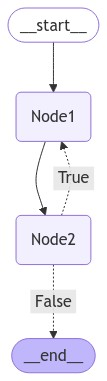

In [54]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [55]:
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values['count'])   

{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ee33-6e8d-800d-9be499f70ebf'}} 4
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ee32-637f-800c-0ef25feb2d14'}} 3
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ee31-6393-800b-bfda45475933'}} 2
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ee2f-6bf2-800a-65dcc4e4ef90'}} 1
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ee2e-6544-8009-4734a62f1f13'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ee2d-6088-8008-53dc15545696'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-2291-630f-8007-d6ce87addc73'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-1d0c-6d5f-8006-bb1b283341c8'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkp

Start by grabbing a state.

In [56]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'count': 0}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe2-4412-676d-8001-f4b01bc29966'}}, metadata={'source': 'loop', 'writes': {'llm': {'messages': [AIMessage(content="I'm sorry but I do not have the capability to perform this task for you, I am happy to help you with any other queries you may have.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 291, 'total_tokens': 323, 'completion_time': 0.099462469, 'prompt_time': 0.021699524, 'queue_time': 0.011361593, 'total_time': 0.121161993}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None}, id='run-d8651cdf-638a-4f29-b5dc-8c7d419bc5cc-0', usage_metadata={'input_tokens': 291, 'output_tokens': 32, 'total_tokens': 323})]}}, 'step': 1, 'parents': {}}, created_at='2024-10-19T09:40:14.123334+00:00', parent_config={'configurable': {'t

Now modify the values. One subtle item to note: Recall when agent state was defined, `count` used `operator.add` to indicate that values are *added* to the current value. Here, `-3` will be added to the current count value rather than replace it.

In [57]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'count': -3, 'scratch': 'hello'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe2-4412-676d-8001-f4b01bc29966'}}, metadata={'source': 'loop', 'writes': {'llm': {'messages': [AIMessage(content="I'm sorry but I do not have the capability to perform this task for you, I am happy to help you with any other queries you may have.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 291, 'total_tokens': 323, 'completion_time': 0.099462469, 'prompt_time': 0.021699524, 'queue_time': 0.011361593, 'total_time': 0.121161993}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None}, id='run-d8651cdf-638a-4f29-b5dc-8c7d419bc5cc-0', usage_metadata={'input_tokens': 291, 'output_tokens': 32, 'total_tokens': 323})]}}, 'step': 1, 'parents': {}}, created_at='2024-10-19T09:40:14.123334+00:00', parent_config

Now update the state. This creates a new entry at the *top*, or *latest* entry in memory. This will become the current state.

In [58]:
graph.update_state(thread2,save_state.values)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8dfe8-fa14-6a13-800e-3a42bcd7a919'}}

Current state is at the top. You can match the `thread_ts`.
Notice the `parent_config`, `thread_ts` of the new node - it is the previous node.

In [59]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-fa14-6a13-800e-3a42bcd7a919'}}, metadata={'source': 'update', 'step': 14, 'writes': {'Node2': {'count': -3, 'scratch': 'hello'}}, 'parents': {}}, created_at='2024-10-19T09:43:14.269614+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ee33-6e8d-800d-9be499f70ebf'}}, tasks=(PregelTask(id='8c269ca5-0718-8901-12e5-33c82d08c057', name='Node1', path=('__pregel_pull', 'Node1'), error=None, interrupts=(), state=None, result=None),)) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-ee33-6e8d-800d-9be499f70ebf'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 13, 'parents': {}}, created_at='2024-

### Try again with `as_node`
When writing using `update_state()`, you want to define to the graph logic which node should be assumed as the writer. What this does is allow th graph logic to find the node on the graph. After writing the values, the `next()` value is computed by travesing the graph using the new state. In this case, the state we have was written by `Node1`. The graph can then compute the next state as being `Node2`. Note that in some graphs, this may involve going through conditional edges!  Let's try this out.

In [60]:
graph.update_state(thread2,save_state.values, as_node="Node1")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8dfe8-fa4d-6042-800f-f998b8462764'}}

In [61]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-fa4d-6042-800f-f998b8462764'}}, metadata={'source': 'update', 'step': 15, 'writes': {'Node1': {'count': -3, 'scratch': 'hello'}}, 'parents': {}}, created_at='2024-10-19T09:43:14.292721+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-fa14-6a13-800e-3a42bcd7a919'}}, tasks=(PregelTask(id='6f84bc19-d912-1cf5-f192-628ccd46173e', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result=None),)) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-fa14-6a13-800e-3a42bcd7a919'}}, metadata={'source': 'update', 'step': 14, 'writes': {'Node2': {'count': -3, 'scratch': 'hello'}}, 'parents': {}}, c

`invoke` will run from the current state if not given a particular `thread_ts`. This is now the entry that was just added.

In [62]:
graph.invoke(None,thread2)

node2, count:-2
node1, count:-1
node2, count:0
node1, count:1
node2, count:2


{'lnode': 'node_2', 'scratch': 'hello', 'count': 3}

Print out the state history, notice the `scratch` value change on the latest entries.

In [63]:
for state in graph.get_state_history(thread2):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-fa7e-6378-8014-0d94a8464162'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 20, 'parents': {}}, created_at='2024-10-19T09:43:14.312881+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-fa7d-6080-8013-2fdc29e51a62'}}, tasks=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-fa7d-6080-8013-2fdc29e51a62'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 19, 'parents': {}}, created_at='2024-10-19T09:43:14.312396+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef8dfe8-fa7c-60e1-8012-708808a9fa2

Continue to experiment!